## Magnetic Model Comparison

This notebook compares the CHAOS-6-Core models evaluated by two different implementations:

- [eoxmagmod](https://github.com/ESA-VirES/MagneticModel/tree/staging/eoxmagmod) (used by VirES)
- [chaosmagpy](http://www.spacecenter.dk/files/magnetic-models/CHAOS-6/) (reference Python implementation)


This version of the notebook corrects the error caused by the different decimal year/MJD2000 conversions:

- The `eoxmagmod` library converts the decimal year to MJD2000 and vice versa so that a whole decimal year is always aligned with the midnight 1st of January.

- The `chaosmagpy` calculates the MJD2000 as $t_\text{MJD200} = 365.25 \times (t_\text{decimal year} - 2000)$

This version redefines the `eoxmagmod` model to use the same conversion as the `chaosmagpy` package.

In addition this version also evaluates values between the interpolation nodes.

In [1]:
from numpy import asarray

def decimal_year_to_mjd2000(decimal_year):
    return (asarray(decimal_year) - 2000) * 365.25

def mjd2000_to_decimal_year(mjd2000):
    return 2000.0 + asarray(mjd2000) / 365.25

### 1) Load SHC model file

In [2]:
from os.path import basename
from eoxmagmod.data import CHAOS6_CORE_LATEST

print(basename(CHAOS6_CORE_LATEST))
print(open(CHAOS6_CORE_LATEST).read())

CHAOS-6-x7_core.shc
# CHAOS-6-x7 core field model                      
# Based on model iteration_1 of CF_CHAOS_09d_18.mat
# extracted on 09-Oct-2018 12:11:25                
  1  20 221   6   5
          1997.1020   1997.2019   1997.3018   1997.4018   1997.5017   1997.6016   1997.7016   1997.8015   1997.9014   1998.0014   1998.1013   1998.2012   1998.3012   1998.4011   1998.5010   1998.6010   1998.7009   1998.8008   1998.9008   1999.0007   1999.1006   1999.2005   1999.3005   1999.4004   1999.5003   1999.6003   1999.7008   1999.8012   1999.9017   2000.0022   2000.1027   2000.2026   2000.3025   2000.4025   2000.5024   2000.6023   2000.7023   2000.8022   2000.9021   2001.0021   2001.1020   2001.2019   2001.3018   2001.4018   2001.5017   2001.6016   2001.7016   2001.8015   2001.9014   2002.0014   2002.1013   2002.2012   2002.3012   2002.4011   2002.5010   2002.6010   2002.7009   2002.8008   2002.9008   2003.0007   2003.1006   2003.2005   2003.3005   2003.4004   2003.5003   2003.6003   20

/usr/local/conda/lib/python3.7/site-packages/spacepy/pycdf/__init__.py:1209: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  class CDF(collections.MutableMapping):


### 2) generate times and locations

In [3]:
# generate random points
from math import pi
from numpy import sin, cos, dstack, linspace
from numpy.random import random, uniform

EARTH_RADIUS = 6371.2 # km
N_coords = 500

X = random((N_coords*2, 2))
X = X[X[..., 1] < sin(X[..., 0]*pi)][:N_coords, ...]
X[..., 0] = pi * (X[..., 0] - 0.5)
X[..., 1] = pi*(2.0*X[..., 1] / cos(X[..., 0]) - 1.0)
X *= 180./pi
lats = X[..., 0]
lons = X[..., 1]
rads = uniform(EARTH_RADIUS, 1.1*EARTH_RADIUS, N_coords)

coords = dstack((lats, lons, rads))[0]

In [4]:
#generate times
from eoxmagmod import load_model_shc
model_vires = load_model_shc(CHAOS6_CORE_LATEST)
N_times = 1000
start, end = model_vires.validity
times = linspace(start, end, num=N_times)
#times = decimal_year_to_mjd2000(model_vires.coefficients._times)
#N_times = len(times)

### 3) evaluate the VirES model

In [5]:
from numpy import empty
from eoxmagmod.magnetic_model.model import SphericalHarmomicGeomagneticModel
from eoxmagmod.magnetic_model.coefficients import SparseSHCoefficientsTimeDependent
from eoxmagmod.magnetic_model.util import parse_file
from eoxmagmod.magnetic_model.parser_shc import parse_shc_file

def load_coeff_shc_mjd2000(path):
    """ Load coefficients from an SHC file (interpolated in the MJD2000 time domain) """
    data = parse_file(parse_shc_file, path)
    options = {
        key: decimal_year_to_mjd2000(data[key])
        for key in ("validity_start", "validity_end") if key in data
    }
    times = data["t"]
    if len(times) == 1:
        return SparseSHCoefficientsConstant(
            data["nm"], data["gh"][:, 0], **options
        )
    else:
        return SparseSHCoefficientsTimeDependent(
            data["nm"], data["gh"], decimal_year_to_mjd2000(times), **options
        )

model_vires = SphericalHarmomicGeomagneticModel(
    load_coeff_shc_mjd2000(CHAOS6_CORE_LATEST)
)

b_nec_vires = empty((N_times, N_coords, 3))

for idx, time in enumerate(times):
    b_nec_vires[idx, ...] = model_vires.eval(time, coords, scale=[1, 1, -1])

### 4) evaluate the refrence model

In [6]:
from chaosmagpy import load_CHAOS_shcfile
model_ref = load_CHAOS_shcfile(CHAOS6_CORE_LATEST)

b_nec_ref = empty((N_times, N_coords, 3))

for idx, time in enumerate(times):
    a, b, c = model_ref(time, rads, 90.0 - lats, lons, source_list=['tdep'])
    b_nec_ref[idx, :, 0] = -b
    b_nec_ref[idx, :, 1] = c
    b_nec_ref[idx, :, 2] = -a

Computing time-dependent internal field up to degree 20.
Finished in 0.0128979 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.012197 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0123097 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0121812 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0121531 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0121228 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0119909 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0120672 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0121826 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0121362 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0130241 seconds.
Computing time-dependent internal

Computing time-dependent internal field up to degree 20.
Finished in 0.0141822 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0120147 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0120667 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0119119 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0119272 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0118981 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0120179 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.011916 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0120696 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0118241 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0117907 seconds.
Computing time-dependent internal

Finished in 0.0140681 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0121698 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0120384 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.012114 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0119585 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0120883 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0120531 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0120792 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0120311 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0119981 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0119547 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0120124 seconds.
Co

Finished in 0.0120001 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0141746 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0122791 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0120994 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0122146 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0120249 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0120678 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0119923 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0119403 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0121425 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.012096 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0120826 seconds.
Co

Finished in 0.01304 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0118759 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0122797 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0119771 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0122777 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0120037 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0118752 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0117016 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.012954 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.011858 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0118127 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0118382 seconds.
Compu

Finished in 0.0121845 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.014147 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0121445 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0122201 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0120573 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0120572 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0120823 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0120401 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0118278 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0122314 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.012051 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0120137 seconds.
Com

Finished in 0.0122194 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.012587 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0118069 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0118126 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0117771 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0117994 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.011633 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0116893 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0116904 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.011798 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0117753 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0118186 seconds.
Comp

Finished in 0.0119995 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0144656 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0121135 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0120212 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0120048 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.012228 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0120231 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.012053 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0119374 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0120943 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0120517 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0120619 seconds.
Com

Finished in 0.0118958 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0121501 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0119379 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0119531 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0120312 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0119983 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0120617 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0119804 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0120027 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.011972 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0120287 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0120158 seconds.
Co

Finished in 0.0137117 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0122859 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0121086 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0120535 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0121097 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0120626 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0120455 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0119779 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.011772 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0121185 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0120561 seconds.
Computing time-dependent internal field up to degree 20.
Finished in 0.0118783 seconds.
Co

### Model comparison

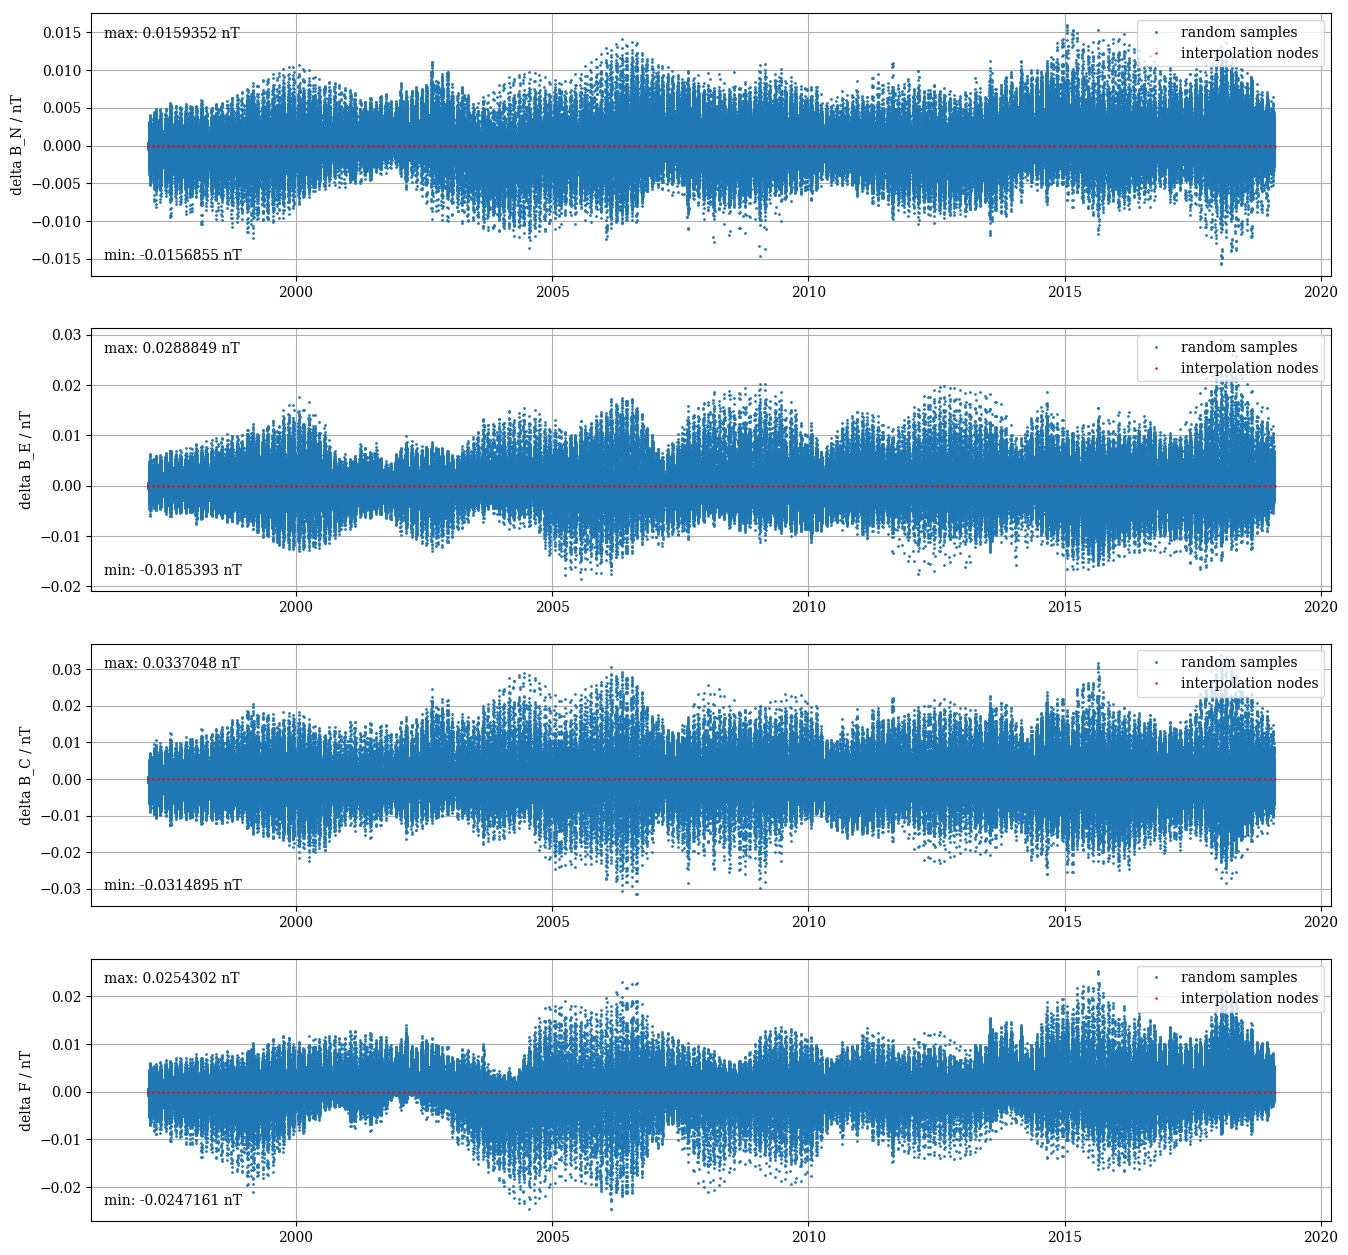

In [7]:
from numpy import zeros, concatenate, isnan
from matplotlib import pyplot as plt
from eoxmagmod import vnorm

node_times = mjd2000_to_decimal_year(model_vires.coefficients._times)
node_val = zeros(node_times.shape)

delta_b_nec = b_nec_vires - b_nec_ref
delta_f = vnorm(b_nec_vires) - vnorm(b_nec_ref)

fig = plt.figure(figsize=(16, 16), dpi=100)
plt.title("eoxmagmod vs chaosmagpy (CHAOS-6-Core, x7)")

times_dy = mjd2000_to_decimal_year(times)

def plot(ax, x0, y0, label):
    x, y = [], []
    for idx in range(0, N_coords):
        x.append(x0)
        y.append(y0[:, idx])
    x, y = concatenate(x), concatenate(y)
    plt.plot(x, y, '.', markersize=2, color='#1f77b4', label='random samples')
    plt.plot(node_times, node_val, '+r', markersize=2, label='interpolation nodes')
    plt.ylabel(label)
    plt.legend(loc='upper right')
    plt.text(
        0.01, 0.95, 'max: %g nT' % y[~isnan(y)].max(),
        horizontalalignment='left', verticalalignment='top', transform=ax.transAxes
    )
    plt.text(
        0.01, 0.05, 'min: %g nT' % y[~isnan(y)].min(),
        horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes
    )
    plt.grid()
    
ax = plt.subplot(4, 1, 1)
plot(ax, times_dy, delta_b_nec[..., 0], "delta B_N / nT")

ax = plt.subplot(4, 1, 2)
plot(ax, times_dy, delta_b_nec[..., 1], "delta B_E / nT")

ax = plt.subplot(4, 1, 3)
plot(ax, times_dy, delta_b_nec[..., 2], "delta B_C / nT")

ax = plt.subplot(4, 1, 4)
plot(ax, times_dy, delta_f, "delta F / nT")

plt.show()
%matplotlib inline

### plot locations

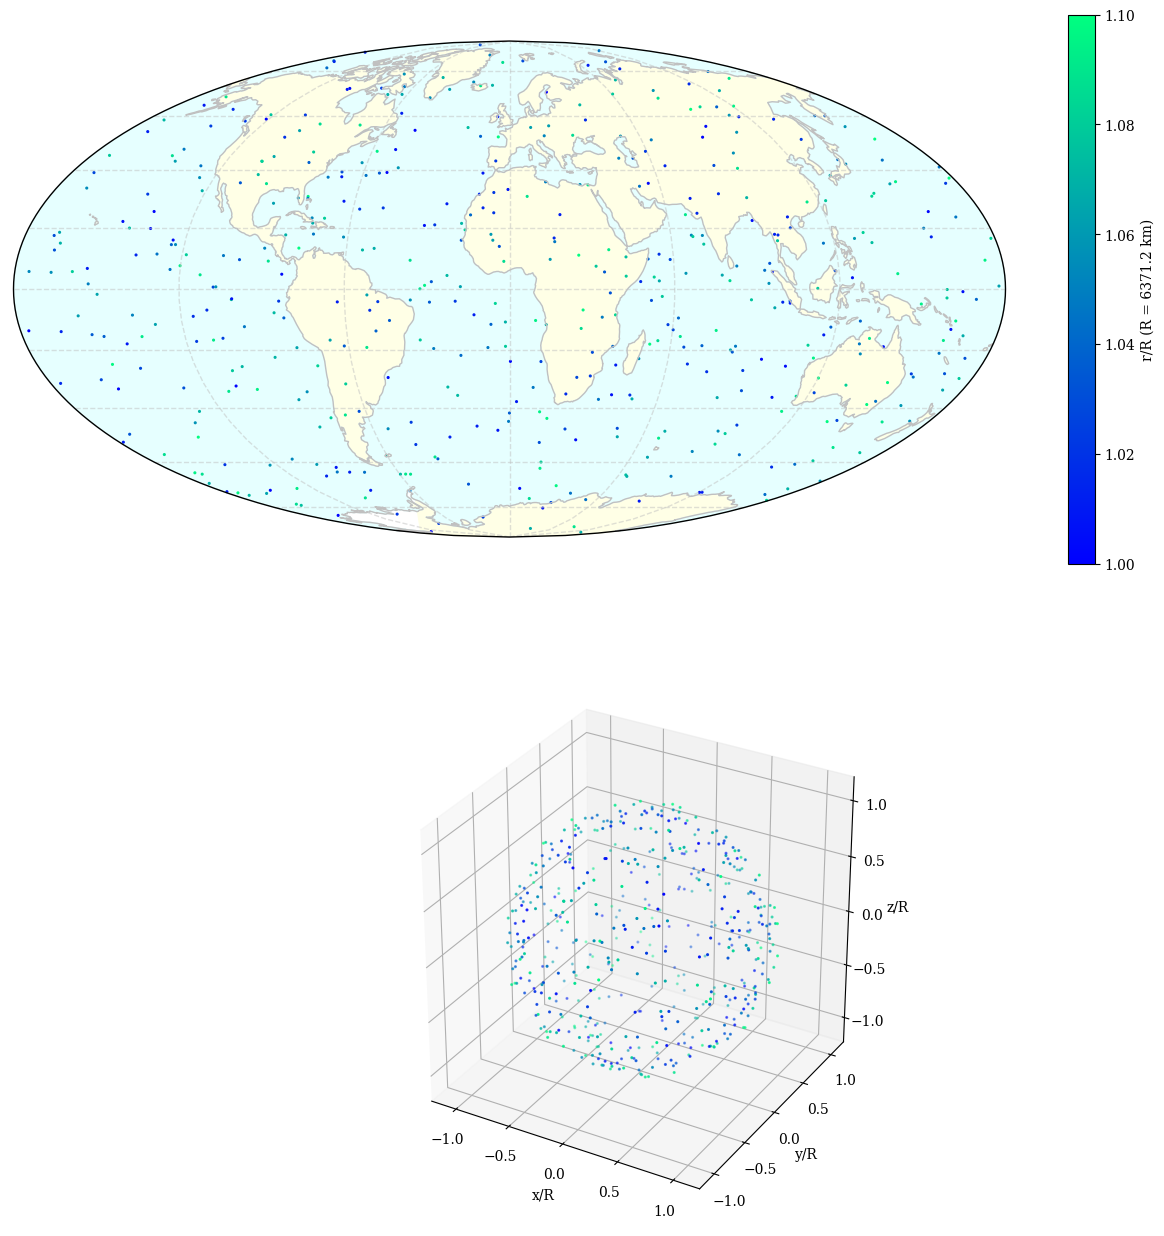

In [8]:
from cartopy.feature import LAND, OCEAN, COASTLINE
from cartopy.crs import Mollweide, PlateCarree
from matplotlib import pyplot as plt
from matplotlib.cm import winter as colormap
from matplotlib.colors import Normalize
from matplotlib.colorbar import ColorbarBase
from mpl_toolkits.mplot3d import Axes3D
from eoxmagmod import convert, GEOCENTRIC_SPHERICAL, GEOCENTRIC_CARTESIAN
%matplotlib inline

norm = Normalize(vmin=1,vmax=1.1)

#help(ccrs)
fig = plt.figure(figsize=(16, 16), dpi=100, facecolor='w', edgecolor='k')
ax = plt.subplot(2, 1, 1, projection=Mollweide())
gl = ax.gridlines(crs=PlateCarree(), draw_labels=False, linewidth=1, color='silver', alpha=0.5, linestyle='--')
ax.add_feature(LAND, facecolor=(1.0, 1.0, 0.9))
ax.add_feature(OCEAN, facecolor=(0.9, 1.0, 1.0))
ax.add_feature(COASTLINE, edgecolor='silver')


obj = ax.scatter(
    lons, lats, c=rads/EARTH_RADIUS, s=1.5,
    cmap=colormap, norm=norm, transform=PlateCarree(),
     
)
cb = plt.colorbar(obj)
cb.ax.set_ylabel("r/R (R = %g km)" % EARTH_RADIUS)


ax = plt.subplot(2, 1, 2, projection='3d')

cart_coords = convert(coords, GEOCENTRIC_SPHERICAL, GEOCENTRIC_CARTESIAN)/EARTH_RADIUS
obj = ax.scatter(
    cart_coords[:, 0], cart_coords[:, 1], cart_coords[:, 2], 
    c=rads/EARTH_RADIUS, s=1.5,
    cmap=colormap, norm=norm,
)

ax.set_aspect('equal','box')
ax.set_xlabel("x/R")
ax.set_ylabel("y/R")
ax.set_zlabel("z/R")

plt.show()